# Recommendation system for E-commerce

- part 1: based on popularity
- part 2: model-based collaborative filtering based on customer's purchase history and ratings provided by other users who bought similar items
- part 3: cold-start, without product rating (?)


References:
- https://www.kaggle.com/shawamar/product-recommendation-system-for-e-commerce

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD

%matplotlib inline

In [2]:
amazon_ratings = pd.read_csv("./data/ratings_Beauty.csv")
amazon_ratings.head()

,UserId,ProductId,Rating,Timestamp
0,A39HTATAQ9V7YF,0205616461,5.0,1369699200
1,A3JM6GV9MNOF9X,0558925278,3.0,1355443200
2,A1Z513UWSAAO0F,0558925278,5.0,1404691200
3,A1WMRR494NWEWV,0733001998,4.0,1382572800
4,A3IAAVS479H7M7,0737104473,1.0,1274227200


In [3]:
# Check for numerical and categorical data.
amazon_ratings.dtypes

UserId        object
ProductId     object
Rating       float64
Timestamp      int64
dtype: object

In [4]:
# Check for null rows. None.
amazon_ratings.isnull().sum()

UserId       0
ProductId    0
Rating       0
Timestamp    0
dtype: int64

In [5]:
# Check dataset size.
amazon_ratings.shape

(2023070, 4)

In [6]:
amazon_ratings.columns

Index(['UserId', 'ProductId', 'Rating', 'Timestamp'], dtype='object')

In [7]:
# Why not using the mean of ratings? Because one product with 5-star rating can rank higher than one product with 10 5-star but 1 1-star rating.
popular_products = pd.DataFrame(amazon_ratings.groupby("ProductId")["Rating"].count())
most_popular = popular_products.sort_values("Rating", ascending=False)
most_popular.head(10)

,Rating
ProductId,
B001MA0QY2,7533
B0009V1YR8,2869
B0043OYFKU,2477
B0000YUXI0,2143
B003V265QW,2088
B000ZMBSPE,2041
B003BQ6QXK,1918
B004OHQR1Q,1885
B00121UVU0,1838


<AxesSubplot:xlabel='ProductId'>

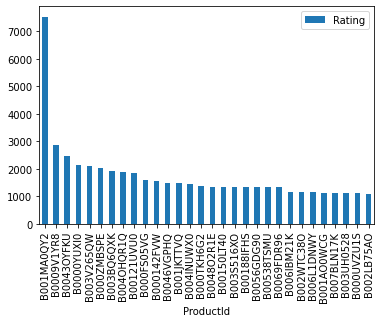

In [8]:
most_popular.head(30).plot(kind="bar")

#### Analysis
- Popular products can be defined by products that are rated the most (not the highest rating)

# Part II

## Model-based collaborative filtering system

In [9]:
# Subset of Amazon Ratings

amazon_ratings_small = amazon_ratings.head(10000)

#### Utility matrix based on products sold and user reviews

Utility matrix consists of all possible user-item preferences (ratings) represented as a matrix. The utility matrix is sparse - no users would buy all items in the list.

In [10]:
ratings_utility_matrix = amazon_ratings_small.pivot_table(
    values="Rating", index="UserId", columns="ProductId", fill_value=0
)
ratings_utility_matrix.head()

ProductId,0205616461,0558925278,0733001998,0737104473,0762451459,1304139212,1304139220,130414089X,130414643X,1304146537,...,B000052YPE,B000052YPF,B000052YPG,B000052YPH,B000052YPM,B000052YPU,B000052YPV,B000052YPY,B000052YQ0,B000052YQ2
UserId,,,,,,,,,,,,,,,,,,,,,
A00205921JHJK5X9LNP42,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A024581134CV80ZBLIZTZ,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03056581JJIOL5FSKJY7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A03099101ZRK4K607JVHH,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A0505229A7NSH3FRXRR4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
ratings_utility_matrix.shape

(9697, 886)

In [12]:
X = ratings_utility_matrix.T
X.shape

(886, 9697)

In [13]:
# Decomposing the matrix.
svd = TruncatedSVD(n_components=10, random_state=10)
decomposed_matrix = svd.fit_transform(X)
decomposed_matrix.shape

(886, 10)

In [14]:
# Correlation matrix
correlation_matrix = np.corrcoef(decomposed_matrix)
correlation_matrix.shape

(886, 886)

In [15]:
# Assuming the customers buy product id `6117036094` (randomly choosen)
product_id = X.index[99]
product_id

'6117036094'

In [16]:
product_names = list(X.index)
product_names[:5]

['0205616461', '0558925278', '0733001998', '0737104473', '0762451459']

In [17]:
product_idx = product_names.index(product_id)
product_idx

99

In [18]:
correlation_product_id = correlation_matrix[product_idx]
correlation_product_id.shape

(886,)

Recommending top 10 highly correlated products in sequence.

In [19]:
recommendations = list(X.index[correlation_product_id > 0.90])

# Remove the item already bought by the customer.
recommendations.remove(product_id)

recommendations[:10]

['0733001998',
 '0762451459',
 '1304139212',
 '1304139220',
 '130414643X',
 '130414674X',
 '1304174778',
 '1304174867',
 '1304174905',
 '1304196046']

## Recommendation System - Part III

- For a business without any user-item purchase history, a search engine based recommendation engine can be designed for users. THe product recommendations can be based on textual clustering analysis given in product description.

In [20]:
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import adjusted_rand_score
from sklearn.neighbors import NearestNeighbors

#### Item to item based recommendation system based on product description


In [21]:
product_descriptions = pd.read_csv("./data/product_descriptions.csv")
product_descriptions.shape

(124428, 2)

#### Check for missing values

In [23]:
product_descriptions.dropna(inplace=True)
product_descriptions.isnull().sum()

product_uid            0
product_description    0
dtype: int64

In [25]:
product_descriptions.head()

,product_uid,product_description
0,100001,"Not only do angles make joints stronger, they ..."
1,100002,BEHR Premium Textured DECKOVER is an innovativ...
2,100003,Classic architecture meets contemporary design...
3,100004,The Grape Solar 265-Watt Polycrystalline PV So...
4,100005,Update your bathroom with the Delta Vero Singl...


In [26]:
product_descriptions_small = product_descriptions.head(500)
product_descriptions_small["product_description"].head()

0    Not only do angles make joints stronger, they ...
1    BEHR Premium Textured DECKOVER is an innovativ...
2    Classic architecture meets contemporary design...
3    The Grape Solar 265-Watt Polycrystalline PV So...
4    Update your bathroom with the Delta Vero Singl...
Name: product_description, dtype: object

#### Feature extraction from product descriptions

In [27]:
vectorizer = TfidfVectorizer(stop_words="english")
X = vectorizer.fit_transform(product_descriptions_small["product_description"])
X

<500x8932 sparse matrix of type '<class 'numpy.float64'>'
	with 34817 stored elements in Compressed Sparse Row format>

#### Visualizing product clusters in subset of data

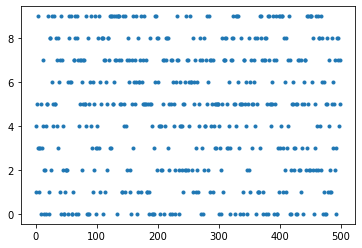

In [28]:
# Fitting k-means to dataset.

kmeans = KMeans(n_clusters=10, init="k-means++", random_state=0)
y_kmeans = kmeans.fit_predict(X)
plt.plot(y_kmeans, ".")
plt.show()

In [29]:
def print_cluster(i):
    print("Cluster {}:".format(i))
    for ind in order_centroids[i, :10]:
        print(" ", terms[ind])
    print

In [32]:
# Optimal clusters can be obtained from elbow method.
true_k = 10
model = KMeans(n_clusters=true_k, init="k-means++", max_iter=100, n_init=1)
model.fit(X)

print("Top term per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print_cluster(i)

Top term per cluster:
Cluster 0:
  concrete
  stake
  used
  steel
  grip
  pliers
  head
  sprinkler
  cement
  garden
Cluster 1:
  door
  ft
  wood
  painted
  proposition
  nbsp
  residents
  california
  65
  post
Cluster 2:
  light
  water
  watt
  led
  installation
  heater
  energy
  year
  bulb
  easy
Cluster 3:
  paint
  water
  easy
  roller
  handle
  ft
  brush
  use
  smooth
  provides
Cluster 4:
  finish
  furniture
  paint
  available
  wood
  using
  includes
  look
  waxes
  dog
Cluster 5:
  metal
  storage
  shelves
  shelf
  unit
  steel
  durable
  adjustable
  lbs
  kitchen
Cluster 6:
  power
  air
  cutting
  volt
  control
  cooling
  20
  easy
  plan
  tool
Cluster 7:
  rug
  bamboo
  shades
  vary
  order
  slightly
  natural
  product
  collection
  size
Cluster 8:
  piece
  toilet
  tile
  design
  flush
  water
  bowl
  insulation
  use
  installation
Cluster 9:
  wall
  plate
  posts
  fence
  post
  panels
  center
  connect
  speaker
  screws


#### Predicting clusters based on key search words.

In [41]:
def show_recommendations(product):
    X = vectorizer.transform([product])
    preds = model.predict(X)
    print_cluster(preds[0])

**Keyword**: cutting tool

In [42]:
show_recommendations("cutting tool")

Cluster 6:
  power
  air
  cutting
  volt
  control
  cooling
  20
  easy
  plan
  tool


**Keyword**: spray paint

In [40]:
show_recommendations("spray paint")

Cluster 3:
  paint
  water
  easy
  roller
  handle
  ft
  brush
  use
  smooth
  provides


In case a word appears in multiple clusters, the algorithm chooses the cluster with the highest frequency of occurance of the word

Once a cluster is identified based on the user's search words, the recommendations system can display items from the corresponding product cluster based on the product descriptions